In [1]:
import matplotlib.pyplot as plt
from gecam.data.hxmt_evt import EvtHxmt
from gecam.plot.light_curve import LightCurveFigure
from gecam.data.spec import SpecFile
from gecam.plot.spectrum import SpectrumFigure

In [3]:
from gecam.time import GecamMet, HebsMet, HxmtMet

In [4]:
trig_met = 74431600.6

In [5]:
# 各个卫星选择不同的时间转换函数

# GECAM: GecamMet,  HEBS: HebsMet, HXMT: HxmtMet
met_func = HxmtMet
# met转时间字符串
trig_time_str = met_func(trig_met).iso
# met转datetime
trig_datetime = met_func(trig_met).datetime
# met转MJD
trig_mjd = met_func(trig_met).mjd

trig_time_str, trig_datetime, trig_mjd

('2014-05-11T11:26:39.600000',
 datetime.datetime(2014, 5, 11, 11, 26, 39, 600000, tzinfo=datetime.timezone.utc),
 56788.47684722222)

In [6]:

evt = EvtHxmt.open(r"E:\gecamTools\test_hxmt\HXMT_HE\HEB221009553\HEB221009553_HE-Evt.fits")

In [7]:
trig_met = evt.info.trig_met
time_range = [trig_met - 50, trig_met + 80]

det_events = evt.select_detector(1)
det_sliced_events = det_events.slice(time_range=time_range)

In [8]:
time_bin = 1
channel_bin = 10

det_sliced_lc = det_sliced_events.to_light_curve(time_bin=time_bin,
                                                 correct_by_dead_time=r"E:\gecamTools\test_hxmt\HXMT_HE\HEB221009553\DeadTime_Proportion.txt")

In [9]:
bg_time_range_list = [[trig_met - 40, trig_met - 30],
                      [trig_met + 25, trig_met + 60]]

# 本底拟合，拟合阶次为2
det_sliced_bg_lc = det_sliced_lc.fit_background(bg_time_range_list, fit_order=1)

C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:266: RankWarning: The fit may be poorly conditioned
  self._coeffs[i] = self._weighted_leastsq(X, y[i], w[i], False)
C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:204: RuntimeWarning: background model has negative value in following channel(s) (starting from 0): 3, 4, 6, 7, 11, 163, 207

This error maybe eliminated by reducing the order of polynomial (the current is 1).
  RuntimeWarning


In [10]:
src_time_range = [trig_met - 1, trig_met + 7]
# 提取源时间段的光变
det_src_lc = det_sliced_events.to_light_curve(src_time_range, time_bin, channel_bin,
                                              correct_by_dead_time=r"E:\gecamTools\test_hxmt\HXMT_HE\HEB221009553\DeadTime_Proportion.txt")

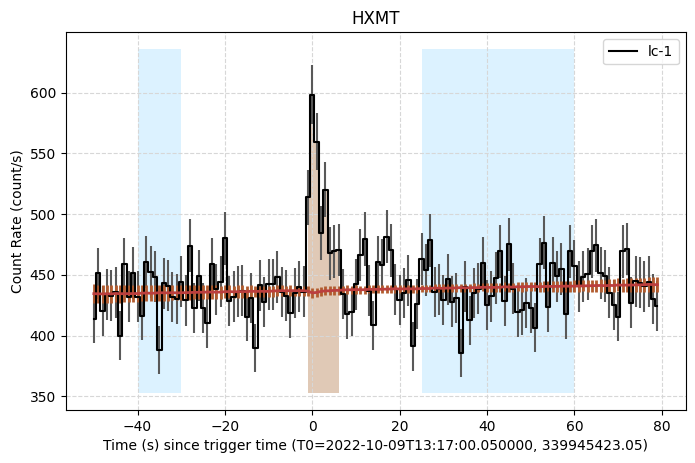

In [11]:
det_sliced_lc_fig = LightCurveFigure(det_sliced_lc.get_plot_data(), trig_time=trig_met,
                                     satellite=evt.info.satellite_full_name)
# # 画出本底
det_sliced_lc_fig.add_background(det_sliced_bg_lc.get_plot_data(),
                                 bg_time_range=det_sliced_bg_lc.bg_time_range)
# 画出源时间段的阴影
det_sliced_lc_fig.add_selection(det_src_lc.get_plot_data())
det_sliced_lc_fig.show_legend()
det_sliced_lc_fig.set_title(evt.info.satellite_full_name)
plt.show()

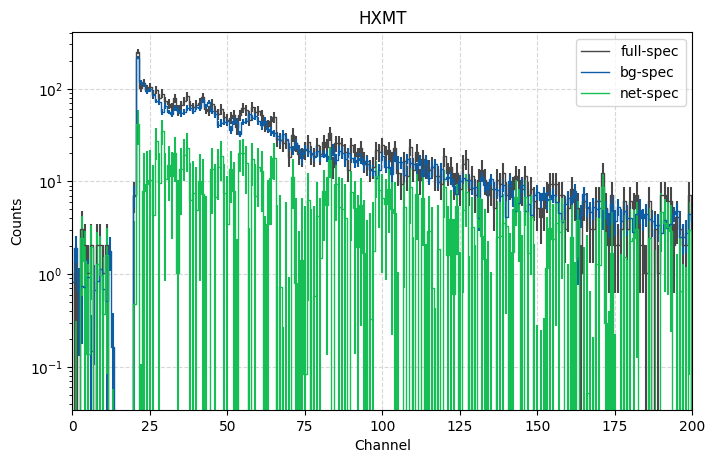

In [13]:
src_time_range = [trig_met - 1, trig_met + 9]
spec_file = SpecFile(det_sliced_lc, det_sliced_bg_lc)
# 添加第一个源时间段
spec, bg_spec, net_spec = spec_file.add_src(src_time_range)

# 画出能谱文件的数据（当前选择第一段源时间段的能谱）
spec_fig = SpectrumFigure()
spec_fig.add_data(spec.get_plot_data(), color="#474747", err_color="#474747", label="full-spec", linewidth=1)
spec_fig.add_data(bg_spec.get_plot_data(), color="#0c5da5", err_color="#0c5da5", label="bg-spec", linewidth=1)
spec_fig.add_data(net_spec.get_plot_data(), color="#16bf55", err_color="#16bf55", label="net-spec", linewidth=1)
# 截断显示
spec_fig.set_xlim([0, 200])
spec_fig.show_legend()
spec_fig.set_title(evt.info.satellite_full_name)
plt.show()

In [ ]:
# 能谱对应的响应文件
rsp_path = "test.rsp"
out_dir = r"E:\gecamTools\test_hxmt\HXMT_HE/"
spec_file.write(out_dir, rsp_path=rsp_path)